In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import allantools
import scipy 

import sktime.transformations.series.kalman_filter as kf


sys.path.append('../../qerr')
sys.path.append('qerr')
sys.path.append('quabo/pano_software')
sys.path.append('quabo/pano_software/util')

from dgnss_utils import panoseti_file_interfaces as pfi
from dgnss_utils import pff
from qerr_utils import *

%matplotlib inline

<Axes: >

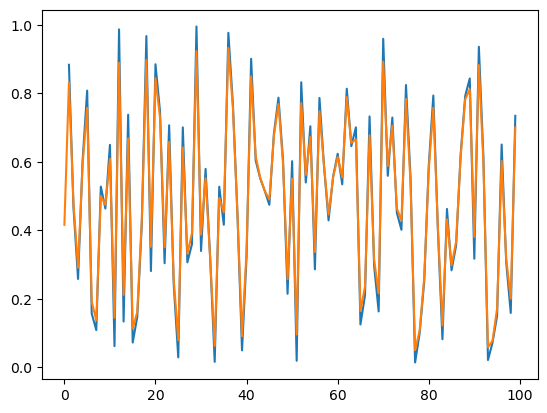

In [25]:
time_steps, state_dim, measurement_dim = 100, 3, 2
X = np.random.rand(time_steps, measurement_dim)
# missing value
X[0][0] = np.nan
# If matrices estimation is required, elements of ``estimate_matrices``
# are assumed to be constants.
transformer = kf.KalmanFilterTransformerPK(  
    state_dim=state_dim,
    measurement_noise=np.eye(measurement_dim),
    denoising=True,
    estimate_matrices=['measurement_noise']
    )
X_transformed = transformer.fit_transform(X=X)  

sns.lineplot(X[:, 0])
sns.lineplot(X_transformed[:, 0])

In [2]:
def load_ph_data(data_dir, run_dir, module_id):
    """
    Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in tqdm(frame_iterator):
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    return ph_df


def load_qerr_df(fpath):
    """
    Load the pd.DataFrame containing quantization error (qerr) data produced by qerr/capture_qerr.py
    """
    df = load_data(fpath)
    df['unix_timestamp'] = pd.to_datetime(df['pkt_unix_timestamp_TIM-TP'], unit='ns')
    # qerr data timestamps are in pacific time
    df['unix_timestamp'] = df['unix_timestamp'].dt.tz_localize('US/Pacific').dt.tz_convert('utc')
    df['qErr (ns)'] = df['qErr (ps)'] * 1e-3
    df = df.sort_values(by='unix_timestamp')
    return df


def align_data(q0, qerr0, q1, qerr1):
    """
    Aligns PH-event and qerr pd.DataFrames to their earliest and latest common timestamps. 
    """
    tsts = {
        'q0': q0,
        'qerr0': qerr0,
        'q1': q1,
        'qerr1': qerr1,
    }
    ealiest_common_timestamp = max(map(lambda s: s['unix_timestamp'].round('ms').min(), tsts.values()))
    latest_common_timestamp = min(map(lambda s: s['unix_timestamp'].round('ms').max(), tsts.values()))

    def trim(df):
        start_idx = np.searchsorted(df['unix_timestamp'], ealiest_common_timestamp, side='right')
        end_idx = np.searchsorted(df['unix_timestamp'], latest_common_timestamp, side='left')
        return df.iloc[start_idx:end_idx].reset_index(drop=True)
        
    aq0, aqerr0, aq1, aqerr1 = trim(q0), trim(qerr0), trim(q1), trim(qerr1)
    new_len = min(len(aq0), len(aqerr0), len(aq1), len(aqerr1))
    return aq0[:new_len], aqerr0[:new_len], aq1[:new_len], aqerr1[:new_len]

## Utils for plotting FFT and plotting power spectrums
def plot_fft_data(fft_data, is_real=False, interactive=False, title=None, ylim_min=-200):
    xlabel = "Frequency (Hz)"
    ylabel = r"Normalized Power (dB)"
    
    with np.errstate(divide='ignore'):
        max_rfreq_idx = np.argmax(fft_data['freqs'])   # Index of max real frequency
        if is_real:
            freqs = fft_data['freqs'][0:max_rfreq_idx + 1]
            # power = np.log10(fft_data['power'][0:max_rfreq_idx + 1])
            # resp = 
            resp = 20 * np.log10(np.abs(fft_data['X'] / abs(fft_data['X']).max()))[0:max_rfreq_idx + 1]
        else:
            freqs = np.roll(fft_data['freqs'], max_rfreq_idx)
            # power = np.log10(np.roll(fft_data['power'], max_rfreq_idx))
            resp = 20 * np.log10(np.abs(fft_data['X'] / abs(fft_data['X']).max()))
            resp = np.roll(resp, max_rfreq_idx)
        valid_idxs = resp > ylim_min
        resp = resp[valid_idxs]
        freqs = freqs[valid_idxs]
    # print(freqs.shape)


        # 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    if interactive:
        fig = px.line(
            x = freqs,
            y = resp,
            title=title,
            height=700
        )
        fig.update_layout(xaxis_title=xlabel,yaxis_title=ylabel)
        fig.show()
    else:
        # (rad / samp) * (1s / 2pi rad)
        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        fig = sns.lineplot(
            x = freqs,
            y = resp,
            ax=ax
        )
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        xticks = np.linspace(np.min(freqs), np.max(freqs), 11)
        ax.set_xticks(xticks)
        # ax.set_ylim(bottom=ylim_min)
        ax.grid('on')
        plt.show()

def apply_fft(x, T=None):
    next_largest_power_of_2 = int(2**(np.ceil(np.log2(len(x)))))
    windowed = np.pad(x, (0, next_largest_power_of_2 - len(x)))

    N = min(len(x), 2**15)       # FFT size
    
    sampling_period = 1

    X = np.fft.fft(x, N)

    freqs = np.fft.fftfreq(len(X), sampling_period) 
    PS = np.abs(X)**2
    fft_data = {
        'X': X,
        'freqs': freqs,
        'power': PS
    }   
    return fft_data

def compute_qerr_align_idx(quabo_df, qerr_df):
    """
    Cross-correlate the qerr (ns) corrections with the quabo nanosecond deviations from the first white rabbit unix timestamp.
    Returns the index by which the QERR data should be rolled (using np.roll) to best align the QERR and quabo timestamp data.
    """
    quabo_ns = quabo_df['wr_timestamp (s)'] - quabo_df['wr_timestamp (s)'][0] # Subtract unix start time
    quabo_ns = quabo_ns % 1    # Keep only the subsecond component
    quabo_ns = quabo_ns * 10**9  # Unit conversion: seconds to nanoseconds
    quabo_ns = quabo_ns.astype(np.float64)
    
    cross_corr = scipy.signal.correlate(quabo_ns, qerr_df['qErr (ns)'], 'full' )
    idx = np.argmax(cross_corr) - len(qerr_df) + 1
    # sns.lineplot(cross_corr)
    # plt.axvline(shift_amount, color='red')
    return idx

def align_qdata_and_qerr(quabo_df, qerr_df):
    idx = compute_qerr_align_idx(quabo_df, qerr_df)
    quabo_data = quabo_df
    qerr_data = qerr_df[-idx:]
    return quabo_data, qerr_data
    
# q0_data, qerr0_data = align_qdata_and_qerr(q0, qerr0)
# common_len = np.min((len(q0_data), len(qerr0_data)))

# sns.lineplot()

def align_data(q0, qerr0, q1, qerr1):
    """
    Aligns PH-event and qerr pd.DataFrames to their earliest and latest common timestamps. 
    """
    
    idx0 = compute_qerr_align_idx(q0, qerr0)
    idx1 = compute_qerr_align_idx(q1, qerr1)

    qerr0 = qerr0.iloc[-idx0:]
    qerr1 = qerr1.iloc[-idx1:]

    tsts = {
        'q0': q0,
        'qerr0': qerr0,
        'q1': q1,
        'qerr1': qerr1,
    }
    ealiest_common_timestamp = max(map(lambda s: s['unix_timestamp'].round('ms').min(), tsts.values()))
    latest_common_timestamp = min(map(lambda s: s['unix_timestamp'].round('ms').max(), tsts.values()))

    def trim(df):
        start_idx = np.searchsorted(df['unix_timestamp'], ealiest_common_timestamp, side='right')
        end_idx = np.searchsorted(df['unix_timestamp'], latest_common_timestamp, side='left')
        return df.iloc[start_idx:end_idx].reset_index(drop=True)
        
    aq0, aqerr0, aq1, aqerr1 = trim(q0), trim(qerr0), trim(q1), trim(qerr1)
    new_len = min(len(aq0), len(aqerr0), len(aq1), len(aqerr1))
    return aq0[:new_len], aqerr0[:new_len], aq1[:new_len], aqerr1[:new_len]

In [3]:
data_dir = 'field_timing_data'
#run_dir = 'obs_UCB_lab.start_2024-08-23T02:40:52Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-08-26T03:58:01Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-08-29T04:29:01Z.runtype_eng-test.pffd'
# run_dir = 'obs_UCB_lab.start_2024-08-29T16:31:13Z.runtype_eng-test.pffd'
run_dir = 'obs_UCB_lab.start_2024-08-30T01:12:04Z.runtype_eng-test.pffd'
# run_dir = 'obs_UCB_lab.start_2024-08-31T15:47:25Z.runtype_eng-test.pffd'
# run_dir = 'obs_UCB_lab.start_2024-09-01T04:18:11Z.runtype_eng-test.pffd'
# run_dir = 'obs_UCB_lab.start_2024-09-03T15:58:34Z.runtype_eng-test.pffd'


qerr0_fpath = glob('%s/%s/qErr/*ttyS10/*MERGED*'%(data_dir,run_dir))[0]
qerr1_fpath = glob('%s/%s/qErr/*ttyUSB0/*MERGED*'%(data_dir,run_dir))[0]

timing0_file = glob('%s/%s/*dp_ph256*_*251*'%(data_dir, run_dir))[0]
timing1_file = glob('%s/%s/*dp_ph256*_*253*'%(data_dir, run_dir))[0]

print(qerr0_fpath.split('/')[-1])
print(qerr1_fpath.split('/')[-1])
print(timing0_file.split('/')[-1])
print(timing1_file.split('/')[-1])


qerr0 = load_qerr_df(qerr0_fpath)
q0 = load_ph_data(data_dir, run_dir, 251)

qerr1 = load_qerr_df(qerr1_fpath)
q1 = load_ph_data(data_dir, run_dir, 253)

pfi.ObservingRunInterface(data_dir, run_dir).obs_pff_files

data-type_MERGED.start_2024-08-29T18:11:27.230202
data-type_MERGED.start_2024-08-29T18:11:15.103059
start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_251.seqno_0.pff
start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_253.seqno_0.pff


44744it [00:34, 1310.76it/s]
27231it [00:15, 1769.12it/s]


{253: {'img': [],
  'ph': [{'fname': 'start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_253.seqno_0.pff',
    'seqno': 0,
    'nframes': 27231,
    'first_unix_t': Decimal('1724980338.602017134'),
    'last_unix_t': Decimal('1725007568.602017129')}]},
 251: {'img': [],
  'ph': [{'fname': 'start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_251.seqno_0.pff',
    'seqno': 0,
    'nframes': 44744,
    'first_unix_t': Decimal('1724980338.602017134'),
    'last_unix_t': Decimal('1725025081.602017132')}]}}

<Axes: ylabel='quabo_wr_diffs (ns)'>

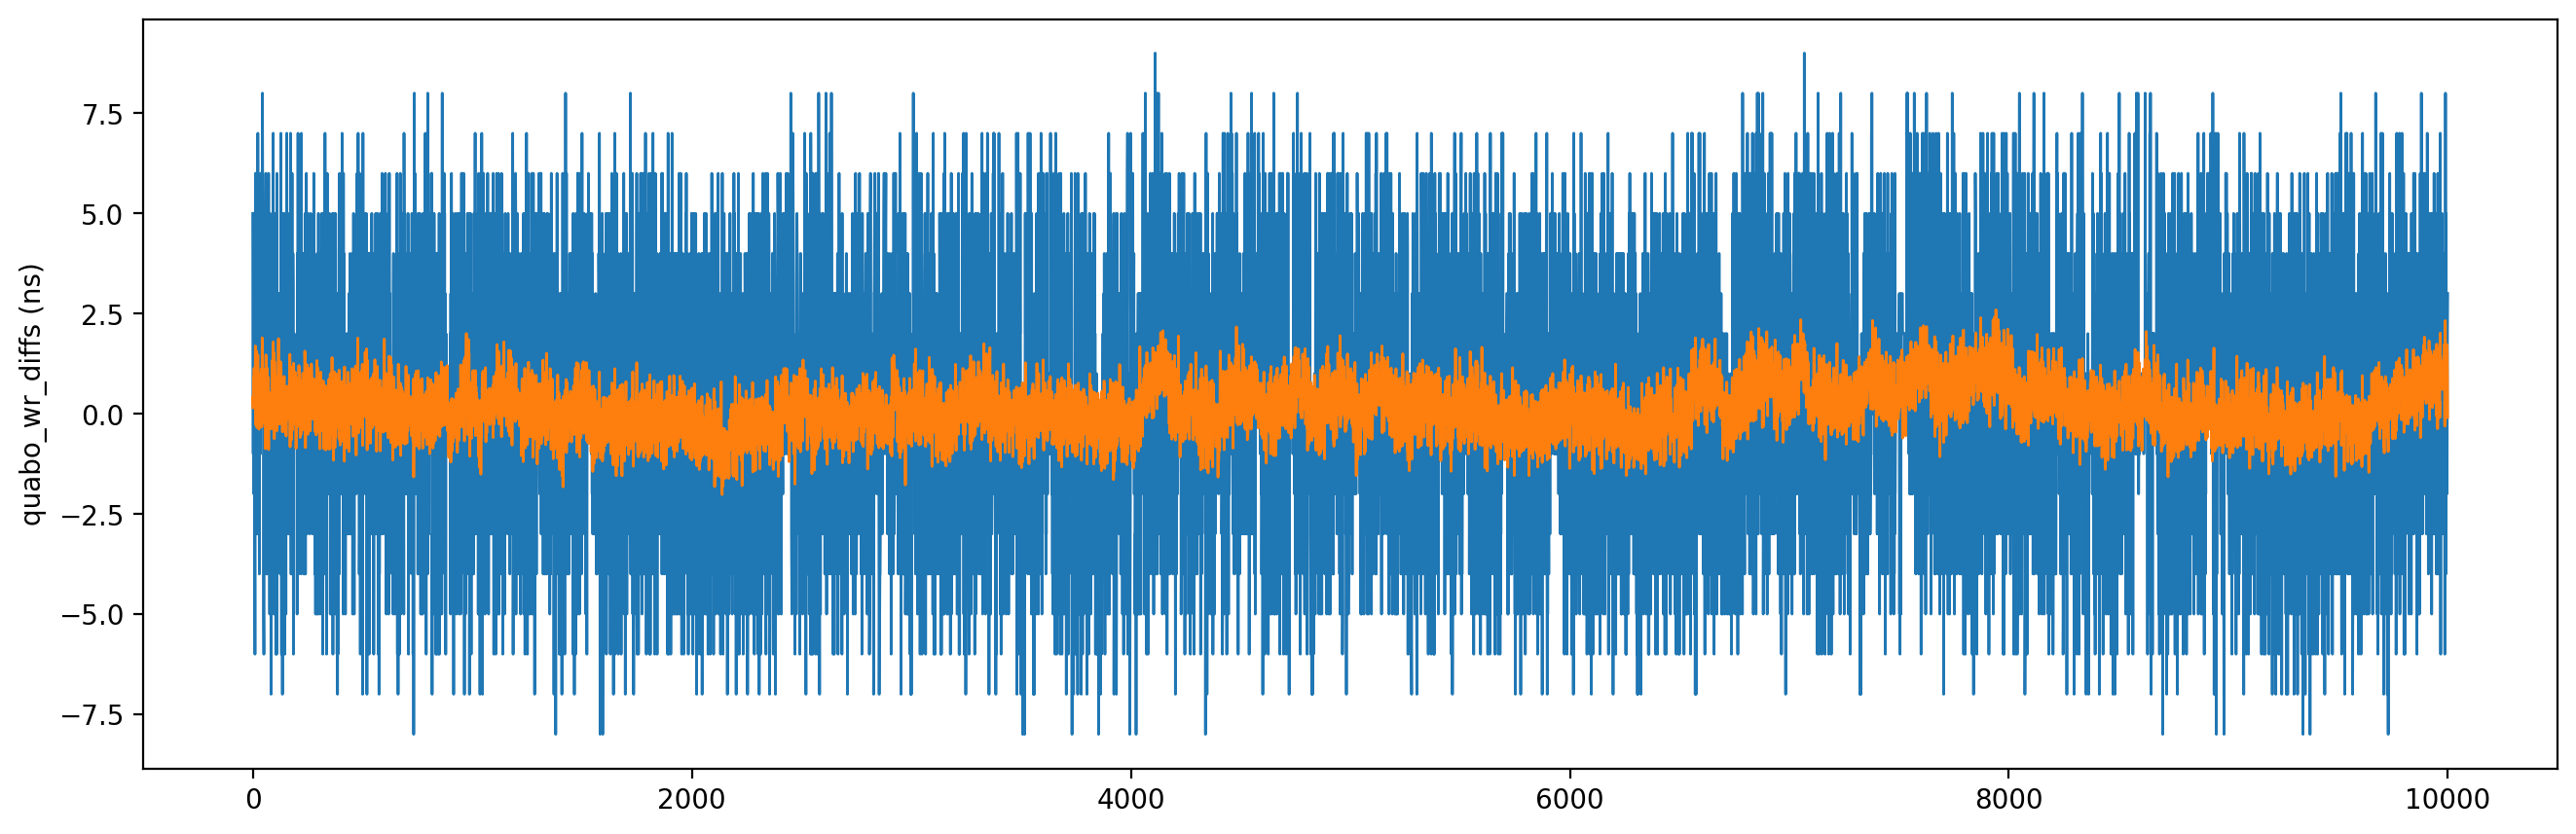

In [4]:
# Align data
aq0, aqerr0, aq1, aqerr1 = align_data(q0, qerr0, q1, qerr1)

# Compute differences
diffs = pd.DataFrame(columns=['quabo_wr_diffs', 'qerr_diffs', 'quabo_wr_diffs_without_qerrs'])

diffs['quabo_wr_diffs (ns)'] = ((aq0['wr_timestamp (s)'] - aq1['wr_timestamp (s)']) * 10**9).astype(np.float64)  # Do second -> nanosecond conversion with Decimal to elimiate floating-point errors
diffs['qerr_diffs (ns)'] = (aqerr1['qErr (ns)'] - aqerr0['qErr (ns)'])
diffs['quabo_wr_diffs_without_qerrs (ns)'] = diffs['quabo_wr_diffs (ns)'] - np.roll(diffs['qerr_diffs (ns)'], 0)

trim = 10000
plt.figure(figsize=(16,5), dpi=200)
sns.lineplot(diffs['quabo_wr_diffs (ns)'].iloc[:trim], linewidth=1)
sns.lineplot(diffs['quabo_wr_diffs_without_qerrs (ns)'].iloc[:trim], linewidth=1)

In [5]:
def plot_lpf_filtered(cutoffs, interactive=False):
    start_timestamp = aq0['unix_timestamp'][0].isoformat()
    total_time = len(aq0)
    
    title = f'1PPS Delta (ns) vs Elapsed Time (s); start = {start_timestamp}'
    xlabel = 'Elapsed Time (s)'
    ylabel = 'Time Delta (ns)'

    ### Create plotting dataframe
    plt_data = {
        "(1PPS Delta) - (qErr Delta)": diffs['quabo_wr_diffs_without_qerrs (ns)'],
    }
    X = diffs['quabo_wr_diffs_without_qerrs (ns)']
    
    for cutoff in cutoffs:
        transformer = Filter(sfreq=1, l_freq=None, h_freq=cutoff)
        X_filtered = transformer.fit_transform(X)
        
        filtered_title = f'LPF: cutoff={cutoff}'
        plt_data[filtered_title] = X_filtered

    plt_df = pd.DataFrame.from_dict(plt_data)

    t_low = 0

    print(plt_df.index)
    if interactive:
        fig = px.line(
            plt_df,
            x = plt_df.index,
            y = plt_df.columns,
            height=600,
            width=1300,
            title=title,
        )
        fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel)
        fig.show()
    else:
        f = plt.figure(figsize=(16, 7), dpi=100)
        ax = plt.gca()
        sns.lineplot(plt_df, linewidth=2)
            
        # Style axis
        xtick_spacing = total_time // 10
        xticks = np.linspace(t_low, longest_len, 20).astype(int)
        xticks = xticks - xticks % 100
        ax.set_xticks(xticks)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.set_title(title)

In [ ]:
cutoffs = np.linspace(0.001, 0.05, 10)
plot_lpf_filtered(cutoffs, interactive=True)

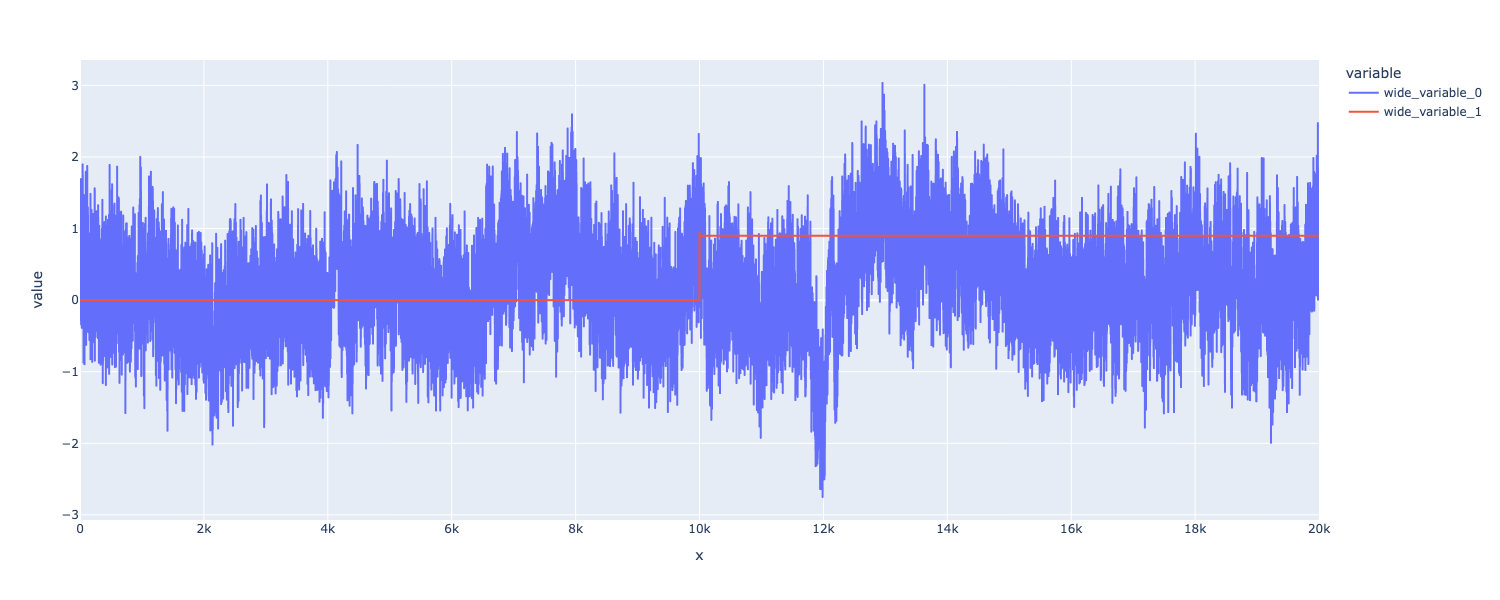

In [88]:
from sktime.transformations.series.filter import Filter

lim = 10000
nftr = 10000
common_len = lim + nftr
y = diffs['quabo_wr_diffs_without_qerrs (ns)']

# X, y = load_arrow_head(return_X_y=True, return_type="pd-multiindex")
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.trend import PolynomialTrendForecaster

# forecaster = ARIMA(  
#     order=(1, 1, 2),
#     # seasonal_order=(0, 1, 0, 2),
#     # enforce_stationarity = True,
#     suppress_warnings=False)

# forecaster = PolynomialTrendForecaster(degree=2)
forecaster = AutoARIMA(
    sp=0, max_d=5, max_p=5, max_q=5, suppress_warnings=True
) 

forecaster.fit(y[:lim])
y_pred = forecaster.predict(fh=np.arange(nftr))

y_pred_shifted = np.zeros(common_len)
y_pred_shifted[-nftr:] = y_pred

fig = px.line(
    x = np.arange(common_len),
    y = [y[:common_len], y_pred_shifted],
    height=600,
    width=1300,
    # title=title,
)
# fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel)
fig.show()